# 0. 대회 개요 및 목표 설정

목표: 주어진 축구 경기 플레이 시퀀스(연속된 이벤트)를 분석하여, 해당 시퀀스의 **마지막 패스가 도착할 좌표(X, Y)**를 예측

평가 지표: 유클리드 거리(Euclidean Distance)

예측 좌표 $(\hat{x}, \hat{y})$와 실제 좌표 $(x, y)$ 사이의 거리가 가까울수록 점수가 높음(오차 최소화).

주요 제약 사항:
- 외부 데이터 사용 금지 (제공된 데이터만 사용)
- Data Leakage 주의: 예측은 각 game_id-episode_id 별로 독립적으로 수행되어야 함 (미래 시점 데이터나, 같은 경기의 다른 에피소드 데이터 참조 금지).
- 좌표계: 105 x 68 (FIFA 권장 규격, L->R 공격 방향 통일됨)

# 1. 환경 설정 및 라이브러리 임포트

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle, Arc
import warnings
warnings.filterwarnings('ignore')

# 판다스 출력 옵션
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# 시각화 스타일 설정
plt.rcParams['font.family'] = 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False

# 2. 데이터 로드 및 초기 검사

## 2-1. 데이터 파일 로드 

In [2]:
# 훈련용 데이터 로드
train_df = pd.read_csv('train.csv')
info_df = pd.read_csv('match_info.csv')

print(f"Train:{train_df.shape}")
print(f"Info:{info_df.shape}")

Train:(356721, 15)
Info:(228, 17)


- Train: 356,721개의 이벤트
- Match Info: 228개의 경기 메타데이터

In [3]:
# 정보
df = train_df.merge(info_df[['game_id','game_date']], how='inner',left_on='game_id', right_on='game_id')

In [4]:
# 시간정보 datetime으로 변경
df['game_date'] = pd.to_datetime(df['game_date'])

In [5]:
# 훈련용 데이터 요약
df.describe(include='all')

,game_id,period_id,episode_id,time_seconds,team_id,player_id,action_id,type_name,result_name,start_x,start_y,end_x,end_y,is_home,game_episode,game_date
count,356721.000000,356721.000000,356721.000000,356721.000000,356721.000000,356721.000000,356721.000000,356721,216467,356721.000000,356721.000000,356721.000000,356721.000000,356721,356721,356721
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,8,NaN,NaN,NaN,NaN,2,15435,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pass,Successful,NaN,NaN,NaN,NaN,True,126408_54,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,178582,178537,NaN,NaN,NaN,NaN,179385,270,NaN
mean,126380.095556,1.499009,42.878479,1473.113221,3835.132347,333341.992406,1466.573333,NaN,NaN,47.259486,34.150991,51.038351,34.127722,NaN,NaN,2024-06-13 08:44:57.847898112
min,126283.000000,1.000000,1.000000,0.000000,316.000000,61616.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,2024-03-01 05:00:00
25%,126331.000000,1.000000,20.000000,693.168000,2354.000000,188233.000000,727.000000,NaN,NaN,29.758365,17.105876,33.516630,16.964164,NaN,NaN,2024-04-27 07:30:00
50%,126379.000000,1.000000,41.000000,1448.633000,4640.000000,354812.000000,1459.000000,NaN,NaN,46.978890,34.265880,50.349495,34.264724,NaN,NaN,2024-06-15 09:00:00
75%,126428.000000,2.000000,64.000000,2241.533000,4646.000000,500145.000000,2192.000000,NaN,NaN,64.429260,51.243304,68.994765,51.257244,NaN,NaN,2024-07-26 10:30:00
max,126480.000000,2.000000,129.000000,3614.467000,4657.000000,534727.000000,3518.000000,NaN,NaN,105.000000,68.000000,105.000000,68.000000,NaN,NaN,2024-10-06 06:00:00


## 2-2. 결측치 및 중복 확인

In [6]:
# 결측치 현황
print(df.isna().sum())
print("'result_name'결측치 : %.1f%%"%(sum(df['result_name'].isna())/len(df)*100))

# 중복 행 확인
print(f"\n완전 중복: {df.duplicated().sum()}개")
print(f"(game_id, action_id) 기준 중복: {df.duplicated(subset=['game_id', 'action_id']).sum()}개")

game_id              0
period_id            0
episode_id           0
time_seconds         0
team_id              0
player_id            0
action_id            0
type_name            0
result_name     140254
start_x              0
start_y              0
end_x                0
end_y                0
is_home              0
game_episode         0
game_date            0
dtype: int64
'result_name'결측치 : 39.3%

완전 중복: 0개
(game_id, action_id) 기준 중복: 0개


In [7]:
type_na = df[df['result_name'].isna()]['type_name'].unique().tolist()
type_not_na = df[~df['result_name'].isna()]['type_name'].unique().tolist()
print('결측치를 갖고 있는 컬럼:',type_na)
list(set(type_na) & set(type_not_na))

결측치를 갖고 있는 컬럼: ['Carry', 'Interception', 'Clearance', 'Recovery', 'Intervention', 'Error', 'Block', 'Parry', 'Catch', 'Hit', 'Deflection', 'Handball_Foul']


[]

## 2-3. 데이터 구조 확인

In [8]:
print(f"총 game_episode수 :{df['game_episode'].nunique()}")

epi_length = df.groupby('game_episode').size()
print(f"\n  Episode별 이벤트 개수 분포:")
print(f"    - 최소: {epi_length.min()}")
print(f"    - 평균: {epi_length.mean():.2f}")
print(f"    - 중앙값: {epi_length.median():.2f}")
print(f"    - 최대: {epi_length.max()}")

총 game_episode수 :15435

  Episode별 이벤트 개수 분포:
    - 최소: 1
    - 평균: 23.11
    - 중앙값: 16.00
    - 최대: 270


In [9]:
first_episode = df['game_episode'].iloc[0]
print(f"  예시: '{first_episode}' 에피소드 구조")
epi_length = df[df['game_episode'] == first_episode]
print(f"    - 이벤트 개수: {len(epi_length)}")
print(f"    - 첫 번째 이벤트:")
print(f"      * 타입: {epi_length.iloc[0]['type_name']}")
print(f"      * 시작: ({epi_length.iloc[0]['start_x']:.2f}, {epi_length.iloc[0]['start_y']:.2f})")
print(f"      * 종료: ({epi_length.iloc[0]['end_x']:.2f}, {epi_length.iloc[0]['end_y']:.2f})")
print(f"    - 마지막 이벤트 (정답으로 사용할 데이터):")
print(f"      * 타입: {epi_length.iloc[-1]['type_name']}")
print(f"      * 시작: ({epi_length.iloc[-1]['start_x']:.2f}, {epi_length.iloc[-1]['start_y']:.2f})")
print(f"      * 종료: ({epi_length.iloc[-1]['end_x']:.2f}, {epi_length.iloc[-1]['end_y']:.2f})")

  예시: '126283_1' 에피소드 구조
    - 이벤트 개수: 49
    - 첫 번째 이벤트:
      * 타입: Pass
      * 시작: (52.42, 33.49)
      * 종료: (31.32, 38.27)
    - 마지막 이벤트 (정답으로 사용할 데이터):
      * 타입: Pass
      * 시작: (101.05, 52.76)
      * 종료: (97.13, 41.79)


In [10]:
print('에피소드 시작 타입: ',set(df.groupby('game_episode')['type_name'].first().values))
print('에피소드 종료 타입: ',set(df.groupby('game_episode')['type_name'].last().values))

에피소드 시작 타입:  {'Pass', 'Foul', 'Goal Kick', 'Throw-In', 'Pass_Corner', 'Shot_Freekick', 'Pass_Freekick'}
에피소드 종료 타입:  {'Pass'}


In [11]:
print('시작 홈팀여부')
print(df.groupby('game_episode')['is_home'].first().value_counts())
print('\n마무리 홈팀여부')
print(df.groupby('game_episode')['is_home'].last().value_counts())

시작 홈팀여부
is_home
True     7742
False    7693
Name: count, dtype: int64

마무리 홈팀여부
is_home
True     7820
False    7615
Name: count, dtype: int64


In [12]:
display(df.groupby('game_episode')[['start_x','end_x']].first().describe())
display(df.groupby('game_episode')[['start_x','end_x']].last().describe())

,start_x,end_x
count,15435.000000,15435.000000
mean,47.362506,53.403581
std,31.378275,27.920487
min,0.000000,0.633256
25%,20.157007,33.366428
50%,49.417830,51.777810
75%,70.304850,74.264505
max,105.000000,105.000000


,start_x,end_x
count,15435.000000,15435.000000
mean,54.918662,68.451987
std,25.380221,23.853429
min,0.000000,0.000000
25%,36.151763,51.964920
50%,56.869260,73.526985
75%,75.648038,87.609008
max,105.000000,105.000000


- 에피소드 시작 및 끝 나는 기준에서 홈팀여부, 시작위치 여부 상관없어 보임

## 2-4. 데이터 범위 검증

In [13]:
df[['start_x', 'start_y', 'end_x', 'end_y']].describe()

,start_x,start_y,end_x,end_y
count,356721.000000,356721.000000,356721.000000,356721.000000
mean,47.259486,34.150991,51.038351,34.127722
std,23.813701,19.800665,24.291506,19.718240
min,0.000000,0.000000,0.000000,0.000000
25%,29.758365,17.105876,33.516630,16.964164
50%,46.978890,34.265880,50.349495,34.264724
75%,64.429260,51.243304,68.994765,51.257244
max,105.000000,68.000000,105.000000,68.000000


- start_x, start_y, end_x, end_y: 좌표 (0\~105 x 0\~68 그리드)
- 범위내 값 확인

## 3. 데이터 전처리 및 정제

In [14]:
def preprocess_football_data(df):
    """
    축구 이벤트 데이터를 정제하는 파이프라인 함수
    Args:
        df(pd.DataFrame): 원본 데이터프레임
    Returns:
        df_clean(pd.DataFrame): 정제된 데이터프레임
    """
    # 원본 데이터 보존을 위해 복사
    df_clean = df.copy()
    
    print(f"Original Shape: {df_clean.shape}")

    # 결측 처리를 위한 이벤트 타입 리스트 (data_description에서 제시된 컬럼명/값 기준)
    neutral_events = ["Block","Carry","Catch","Clearance","Deflection","Error","Foul",
                      "Foul_Throw","Goal","Handball_Foul","Hit","Interception","Intervention","Offside",
                      "Out","Own Goal","Parry","Penalty Kick","Recovery","Shot","Throw-In"]
    
    # type_name의 기본 결측치를 가지고 있는 컬럼인 경우 'Completed'로 채움
    # 나머지 NaN은 'Unknown'으로 채워 정보 손실 방지

    condition = (df_clean['type_name'].isin(neutral_events)) & (df_clean['result_name'].isna())
    df_clean.loc[condition, 'result_name'] = 'Completed'

    # 남은 결측치는 'Unknown'으로 처리
    df_clean['result_name'] = df_clean['result_name'].fillna('Unknown')

    print(f"Missing values in 'result_name' after processing: {df_clean['result_name'].isna().sum()}")

    # 월별 피처 (month) 추가
    df_clean['month'] = df_clean['game_date'].dt.month

    # 이상치 탐지 및 처리
    # A. 좌표 데이터 (Physical Constraints)
    # 축구장 규격: x (0~105), y (0~68)
    # describe() 결과 Max값이 105, 68로 정상이지만, 음수나 초과값이 있는지 방어적 코딩 필요
    
    coord_cols = ['start_x', 'start_y', 'end_x', 'end_y']
    
    # 좌표 클리핑 (Clipping): 범위를 벗어난 값을 경계값으로 치환
    df_clean['start_x'] = df_clean['start_x'].clip(0, 105)
    df_clean['end_x'] = df_clean['end_x'].clip(0, 105)
    df_clean['start_y'] = df_clean['start_y'].clip(0, 68)
    df_clean['end_y'] = df_clean['end_y'].clip(0, 68)

    # B. 시간 데이터 (Statistical Outliers)
    # time_seconds가 비정상적으로 큰 경우 (예: 전반전인데 3000초 초과 등)
    # Boxplot 기반 IQR 방식 적용
    
    Q1 = df_clean['time_seconds'].quantile(0.25)
    Q3 = df_clean['time_seconds'].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    
    # 시간 이상치는 제거하지 않고 'is_time_outlier' 플래그 생성 (중요한 추가시간일 수 있음)
    df_clean['is_time_outlier'] = np.where(df_clean['time_seconds'] > upper_bound, 1, 0)
    
    return df_clean

In [15]:
df_processed = preprocess_football_data(df)
print(df_processed[['type_name','result_name','month']].head())

Original Shape: (356721, 16)
Missing values in 'result_name' after processing: 0
  type_name result_name  month
0      Pass  Successful      3
1      Pass  Successful      3
2     Carry   Completed      3
3      Pass  Successful      3
4      Pass  Successful      3


# 3. EDA 탐색적 데이터분석

## 3-1. 이벤트 타입 분석

type_name
Pass            178582
Carry            82046
Recovery         27352
Interception     11088
Duel              8734
Name: count, dtype: int64


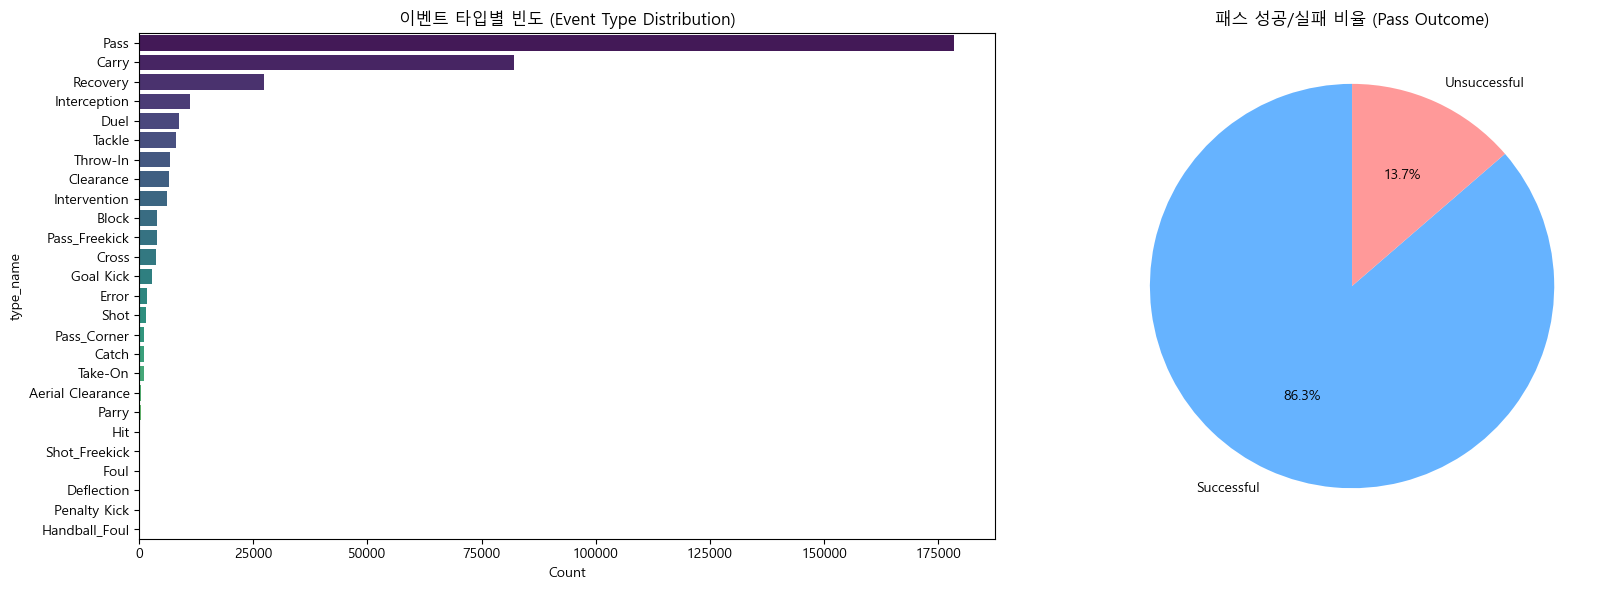

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Bar Chart
type_counts = df_processed['type_name'].value_counts()
print(type_counts.head(5))
sns.barplot(x=type_counts.values, y=type_counts.index, ax=axes[0], palette='viridis')
axes[0].set_title('이벤트 타입별 빈도 (Event Type Distribution)')
axes[0].set_xlabel('Count')

pass_df = df_processed[df_processed['type_name'] == 'Pass']
result_counts = pass_df['result_name'].value_counts()

# Pie Chart
axes[1].pie(result_counts, labels=result_counts.index, autopct='%1.1f%%', 
            colors=['#66b3ff', '#ff9999', '#99ff99'], startangle=90)
axes[1].set_title('패스 성공/실패 비율 (Pass Outcome)')

plt.tight_layout()
plt.show()

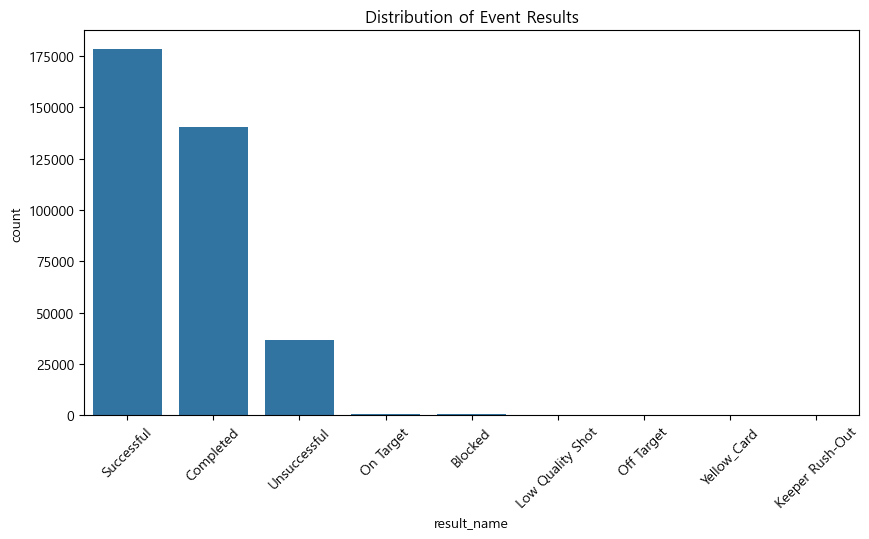

In [17]:
# 결과값 분포 확인 (Class Imbalance 체크)
plt.figure(figsize=(10, 5))
sns.countplot(data=df_processed, x='result_name', order=df_processed['result_name'].value_counts().index)
plt.title('Distribution of Event Results')
plt.xticks(rotation=45)
plt.show()

In [18]:
df_processed.groupby('result_name')['game_id'].count()

result_name
Blocked                635
Completed           140254
Keeper Rush-Out         12
Low Quality Shot        71
Off Target              48
On Target              692
Successful          178537
Unsuccessful         36446
Yellow_Card             26
Name: game_id, dtype: int64

- Pass: 178,582개 (대부분 차지함)
- Carry: 82,046
- 패스 성공확률: 86.3%
- 패스 실패확률: 13.7%

#### 분포 특성 (Distribution)
- 클래스 불균형: Successful, Completed가 압도적으로 많습니다. 실패(Fail, Offside 등) 케이스가 적으므로, 예측 모델링 시 SMOTE나 Class Weight 조정이 필수적입니다.

## 3-2. 시간 데이터 분석(시간별 이벤트 수)

period_id
1    178714
2    178007
Name: count, dtype: int64
count    356721.000000
mean       1473.113221
std         892.281460
min           0.000000
25%         693.168000
50%        1448.633000
75%        2241.533000
max        3614.467000
Name: time_seconds, dtype: float64


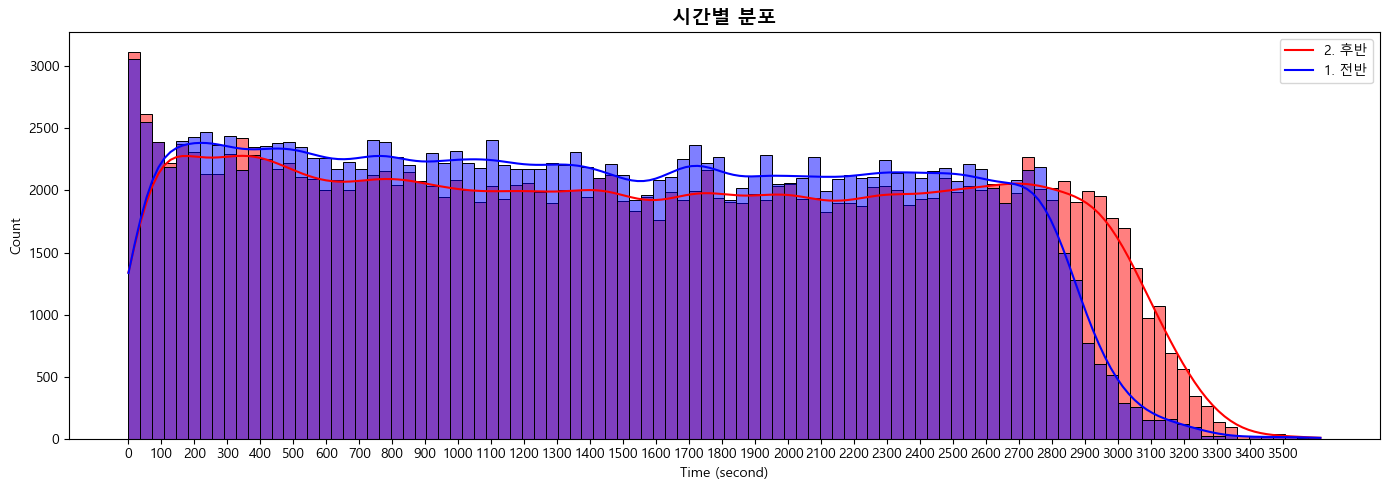

In [19]:
print(df_processed['period_id'].value_counts()) # 전/후반 이벤트 분포
print(df_processed['time_seconds'].describe()) # Period 후 경과 시간 통계

plt.subplots(figsize=(14,5))
sns.histplot(data=df_processed, x='time_seconds', hue='period_id', bins=100, palette=['blue','red'],
            edgecolor='black', kde='True')
plt.legend(['2. 후반','1. 전반'])
plt.xlabel('Time (second)')
plt.title('시간별 분포',fontdict={'fontsize':14, 'fontweight':'bold'})
plt.xticks(np.arange(0,3600,step=100))
plt.tight_layout()
plt.show()

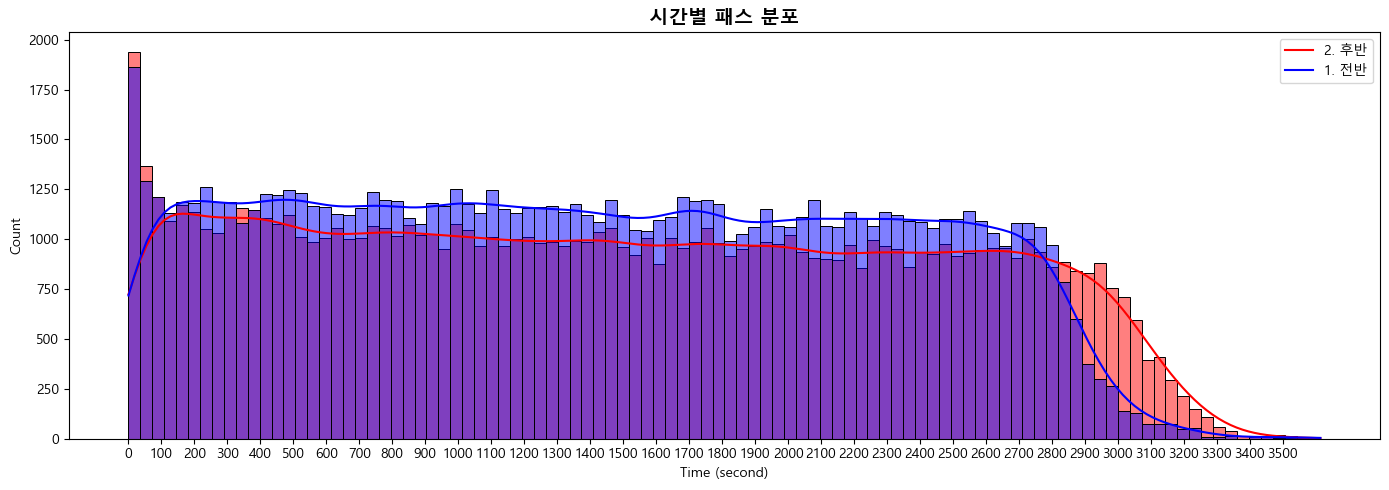

In [20]:
plt.subplots(figsize=(14,5))
sns.histplot(data=pass_df, x='time_seconds', bins=100, hue='period_id', palette=['blue','red'], 
             edgecolor='black', kde='True')
plt.legend(['2. 후반','1. 전반'])
plt.xlabel('Time (second)')
plt.title('시간별 패스 분포',fontdict={'fontsize':14, 'fontweight':'bold'})
plt.xticks(np.arange(0,3600,step=100))
plt.tight_layout()
plt.show()

- 전반/후반 이벤트 수 유사
- 전반적으로 전반전 정규시간에 이벤트 수 후반전 보다 많음
- 후반전은 정규시간 이후 이벤트수 전반전 보다 많음
- 시간값은 0~3614초 (약 60분) 범위
- 정규시간 이후 2700초(45분)이후 이벤트 수가 하락하는 것으로 보임

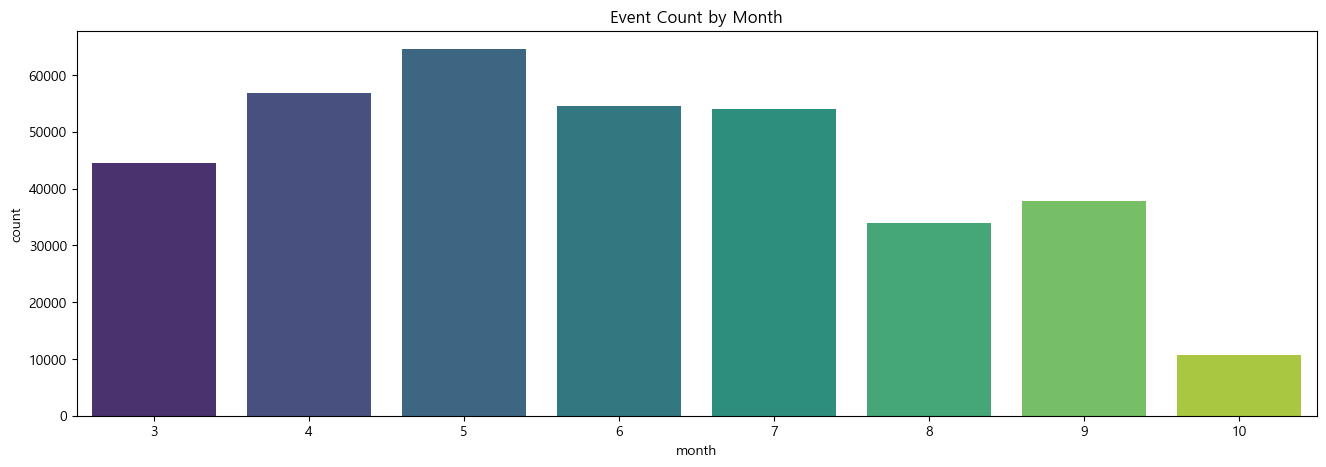

In [21]:
# 월별 이벤트 빈도
plt.subplots(figsize=(16, 5))
sns.countplot(data=df_processed, x='month', palette='viridis')
plt.title('Event Count by Month')
plt.show()

In [22]:
df_processed.groupby('month')['game_id'].count()

month
3     44470
4     56761
5     64584
6     54495
7     53945
8     33950
9     37782
10    10734
Name: game_id, dtype: int64

- 월별 추이: 특정 월(10월)에 데이터가 급감한다면(예: 휴식기) 시계열 모델링 시 주의해야 합니다.

- 3월에서 5월까지 이벤트 수 증가
- 6월에서 10월까지 하락
- 10월 최저수

## 3-3. 팀/선수 데이터 분석

고유 팀 수: 12

팀의 이벤트 개수 분포:
count       12.000000
mean     29726.750000
std       1746.211022
min      26812.000000
25%      28667.750000
50%      29538.000000
75%      30585.750000
max      32954.000000
Name: count, dtype: float64

고유 선수 수: 446
선수의 이벤트 개수 분포:
count     446.000000
mean      799.822870
std       795.416834
min         1.000000
25%       165.500000
50%       512.000000
75%      1208.250000
max      3668.000000
dtype: float64


Text(0.5, 1.0, 'Top 10 Players by Event Count')

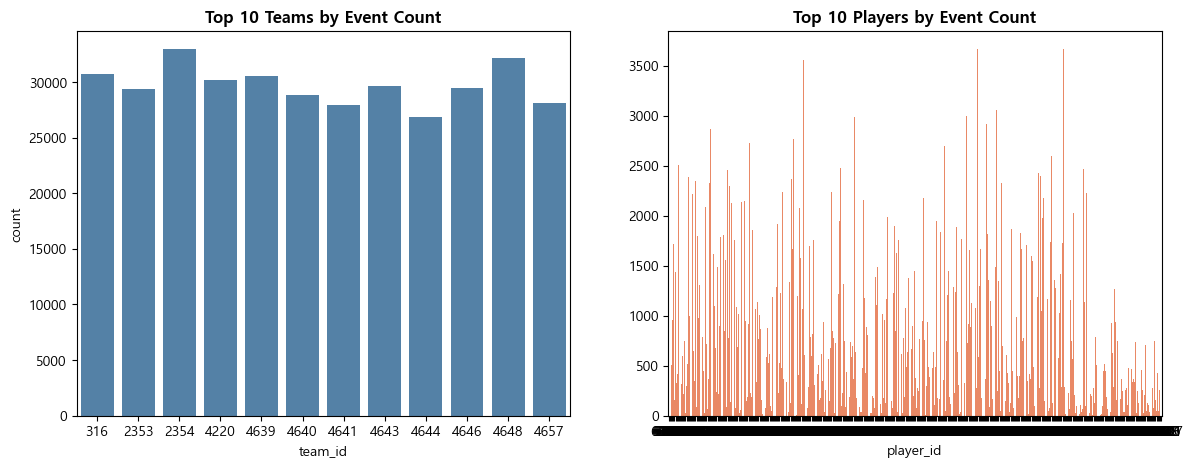

In [23]:
print(f"고유 팀 수: {df_processed['team_id'].nunique()}")
print("\n팀의 이벤트 개수 분포:")
print(df_processed['team_id'].value_counts().describe())

print(f"\n고유 선수 수: {df_processed['player_id'].nunique()}")
print("선수의 이벤트 개수 분포:")
print(df_processed.groupby('player_id').size().describe())

fig, axes = plt.subplots(1,2, figsize=(14,5))

sns.barplot(df_processed['team_id'].value_counts(), ax=axes[0], color='steelblue')
axes[0].set_title('Top 10 Teams by Event Count', fontsize=12, fontweight='bold')

sns.barplot(df_processed.groupby('player_id').size(),
           ax=axes[1], color='coral')
axes[1].set_title('Top 10 Players by Event Count', fontsize=12, fontweight='bold')

고유 팀 수: 12

팀의 패스 이벤트 개수 분포:
count       12.000000
mean     14881.833333
std       1228.588461
min      12595.000000
25%      14265.500000
50%      14960.500000
75%      15585.250000
max      17272.000000
Name: count, dtype: float64

고유 선수 수: 446
선수의 패스 이벤트 개수 분포:
count     446.000000
mean      400.408072
std       416.344676
min         1.000000
25%        71.250000
50%       242.000000
75%       599.750000
max      1913.000000
dtype: float64


Text(0.5, 1.0, 'Top 10 Players by Pass Event Count')

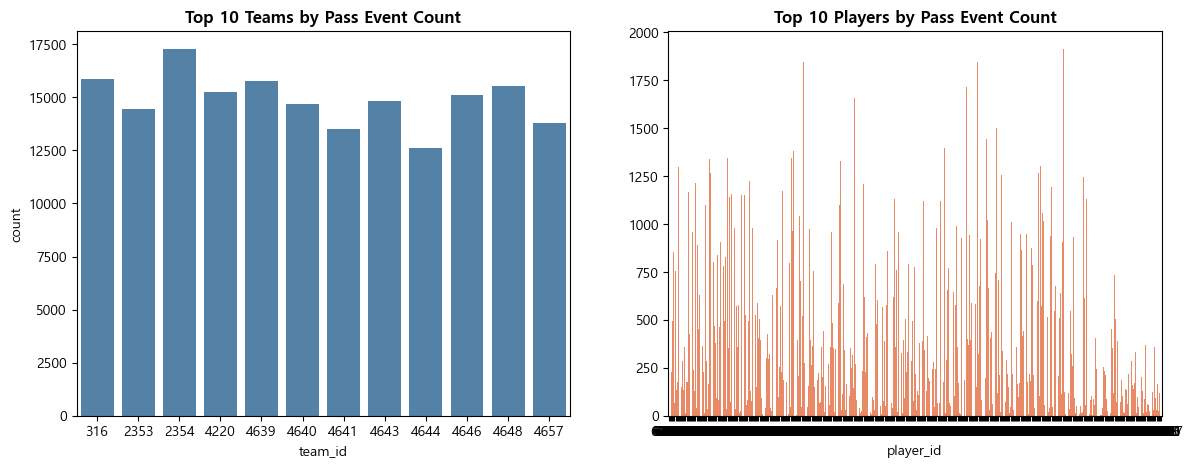

In [24]:
print(f"고유 팀 수: {pass_df['team_id'].nunique()}")
print("\n팀의 패스 이벤트 개수 분포:")
print(pass_df['team_id'].value_counts().describe())

print(f"\n고유 선수 수: {pass_df['player_id'].nunique()}")
print("선수의 패스 이벤트 개수 분포:")
print(pass_df.groupby('player_id').size().describe())

fig, axes = plt.subplots(1,2, figsize=(14,5))

sns.barplot(pass_df['team_id'].value_counts(), ax=axes[0], color='steelblue')
axes[0].set_title('Top 10 Teams by Pass Event Count', fontsize=12, fontweight='bold')

sns.barplot(pass_df.groupby('player_id').size(),
           ax=axes[1], color='coral')
axes[1].set_title('Top 10 Players by Pass Event Count', fontsize=12, fontweight='bold')

- 팀별 분포는 고름
- 선수별 분포는 다양
- 선수별 패스 거리 연관성 확인

## 3-4. 에피소드 분석

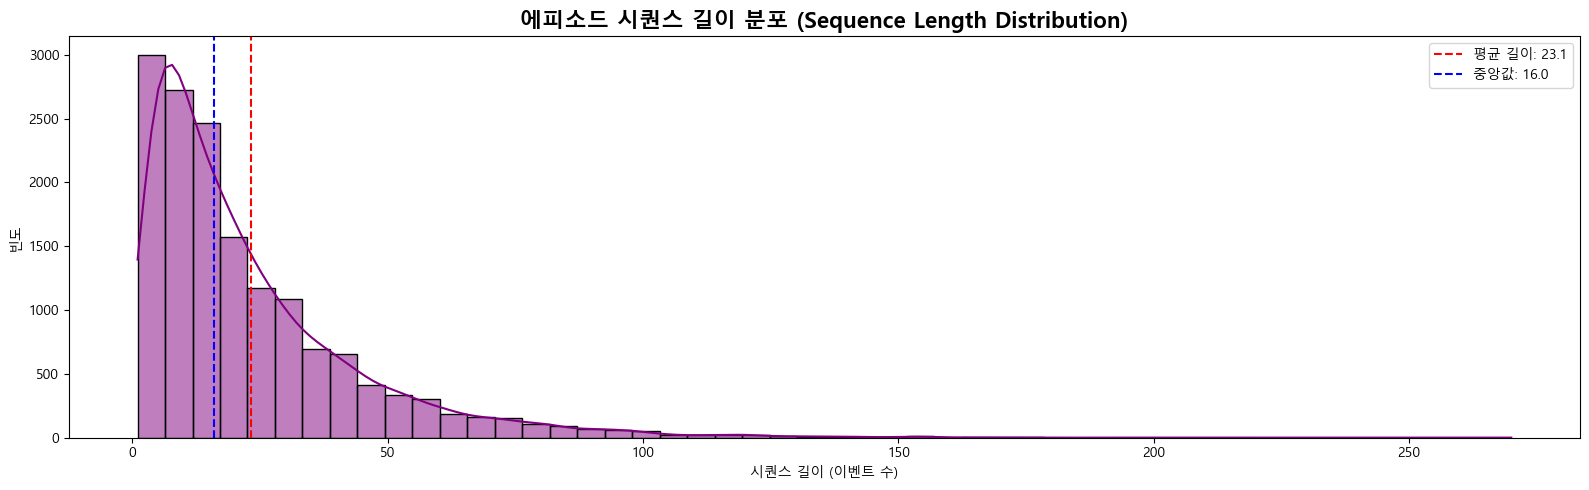

최소 길이: 1, 최대 길이: 270


In [25]:
# 에피소드별 이벤트 개수
episode_lengths = df_processed.groupby('game_episode').size()

plt.figure(figsize=(16, 5))
sns.histplot(episode_lengths, bins=50, kde=True, color='purple')
plt.axvline(episode_lengths.mean(), color='red', linestyle='--', label=f'평균 길이: {episode_lengths.mean():.1f}')
plt.axvline(episode_lengths.median(), color='blue', linestyle='--', label=f'중앙값: {episode_lengths.median():.1f}')
plt.title('에피소드 시퀀스 길이 분포 (Sequence Length Distribution)',fontdict={'fontsize':16, 'fontweight':'bold'})
plt.xlabel('시퀀스 길이 (이벤트 수)')
plt.ylabel('빈도')
plt.legend()
plt.tight_layout()
plt.show()

print(f"최소 길이: {episode_lengths.min()}, 최대 길이: {episode_lengths.max()}")

### 3-4-1. 분포 패턴 및 해석
1. 오른쪽 꼬리가 긴 분포 (Right-skewed Distribution)
    - 짧은 시퀀스가 많음: 대부분의 공격은 2-5개의 패스로 끊기거나 볼 손실이 발생
    - 중간 길이 시퀀스: 10-20개 이벤트로 구성된 조직적인 빌드업
    - 긴 시퀀스 (극소수): 30개 이상의 이벤트로 이어지는 긴 점유 플레이 (매우 드묾)

2. 평균 vs 중앙값 비교
    - 중앙값 < 평균: 이는 오른쪽 꼬리 분포를 확인시켜줍니다
    - 극단적으로 긴 시퀀스 몇 개가 평균을 끌어올립니다
    - 중앙값이 실제 "전형적인" 시퀀스 길이를 더 잘 나타냅니다

3. 모델링 관점에서의 시사점
시퀀스 길이 다양성의 의미:
    - 짧은 시퀀스 (< 5개): 빠른 역습, 인터셉트 직후 공격, 단순 볼 손실
    - 중간 시퀀스 (5-15개): 일반적인 빌드업 플레이, 예측 모델의 주요 학습 대상
    - 긴 시퀀스 (15+개): 점유 중심 플레이, 희소하지만 중요한 패턴

### 3-4-2 시퀀스 분석

In [26]:
# 백분위 분석
percentiles = episode_lengths.quantile([0.25,0.5,0.75,0.9,0.95,0.99])
print('백분위수별 시퀀스 길이:')
print(percentiles)

백분위수별 시퀀스 길이:
0.25      8.0
0.50     16.0
0.75     31.0
0.90     51.0
0.95     67.0
0.99    102.0
dtype: float64


In [27]:
# 시퀀스 길이별 샘플 개수
print(f"5개 이하: {(episode_lengths <= 5).sum()} ({(episode_lengths <= 5).mean()*100:.1f}%)")
print(f"6-15개: {((episode_lengths > 5) & (episode_lengths <= 15)).sum()} ({((episode_lengths > 5) & (episode_lengths <= 15)).mean()*100:.1f}%)")
print(f"16개 이상: {(episode_lengths > 15).sum()} ({(episode_lengths > 15).mean()*100:.1f}%)")

5개 이하: 2364 (15.3%)
6-15개: 5057 (32.8%)
16개 이상: 8014 (51.9%)


## 3-5. 경기장 시각화

In [28]:
def draw_pitch(ax):
    # 경기장 외곽선 (105m x 68m)
    ax.plot([0, 0, 105, 105, 0], [0, 68, 68, 0, 0], color="black")
    
    # 중앙선
    ax.plot([52.5, 52.5], [0, 68], color="black")
    
    # 센터 서클
    center_circle = plt.Circle((52.5, 34), 9.15, color="black", fill=False)
    ax.add_patch(center_circle)
    
    # 페널티 박스 (왼쪽/오른쪽)
    left_penalty = Rectangle((0, 13.84), 16.5, 40.32, fill=False, color="black")
    right_penalty = Rectangle((105-16.5, 13.84), 16.5, 40.32, fill=False, color="black")
    ax.add_patch(left_penalty)
    ax.add_patch(right_penalty)
    
    # 골 에어리어
    left_six = Rectangle((0, 24.84), 5.5, 18.32, fill=False, color="black")
    right_six = Rectangle((105-5.5, 24.84), 5.5, 18.32, fill=False, color="black")
    ax.add_patch(left_six)
    ax.add_patch(right_six)
    
    # 페널티 스팟 & 센터 스팟
    ax.scatter([11, 52.5, 105-11], [34, 34, 34], color="black", s=15)
    
    ax.set_xlim(-5, 110)
    ax.set_ylim(-5, 73)
    ax.set_aspect('equal')
    ax.axis('off')

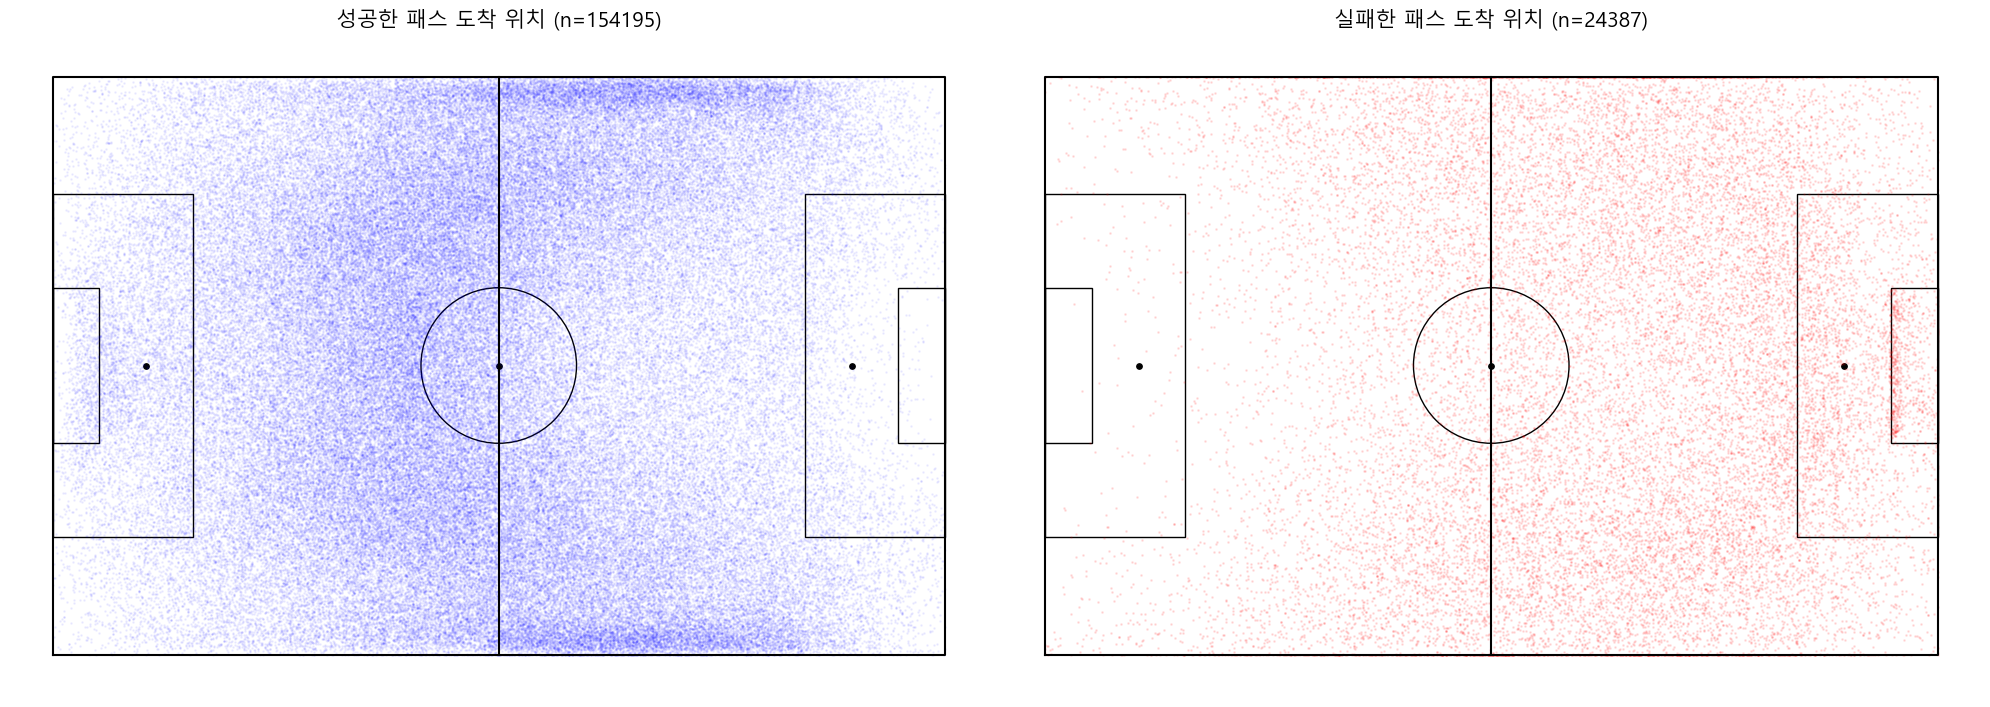

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# 성공한 패스의 도착 위치
successful_passes = pass_df[pass_df['result_name'] == 'Successful']

draw_pitch(axes[0])
# 투명도를 주어 밀집도 표현
axes[0].scatter(successful_passes['end_x'], successful_passes['end_y'], 
                alpha=0.05, s=1, color='blue', label='Successful Pass End')
axes[0].set_title(f'성공한 패스 도착 위치 (n={len(successful_passes)})', fontsize=15)

# 실패한 패스의 도착 위치
failed_passes = pass_df[pass_df['result_name'] != 'Successful']

draw_pitch(axes[1])
axes[1].scatter(failed_passes['end_x'], failed_passes['end_y'], 
                alpha=0.1, s=1, color='red', label='Failed Pass End')
axes[1].set_title(f'실패한 패스 도착 위치 (n={len(failed_passes)})', fontsize=15)

plt.tight_layout()
plt.show()

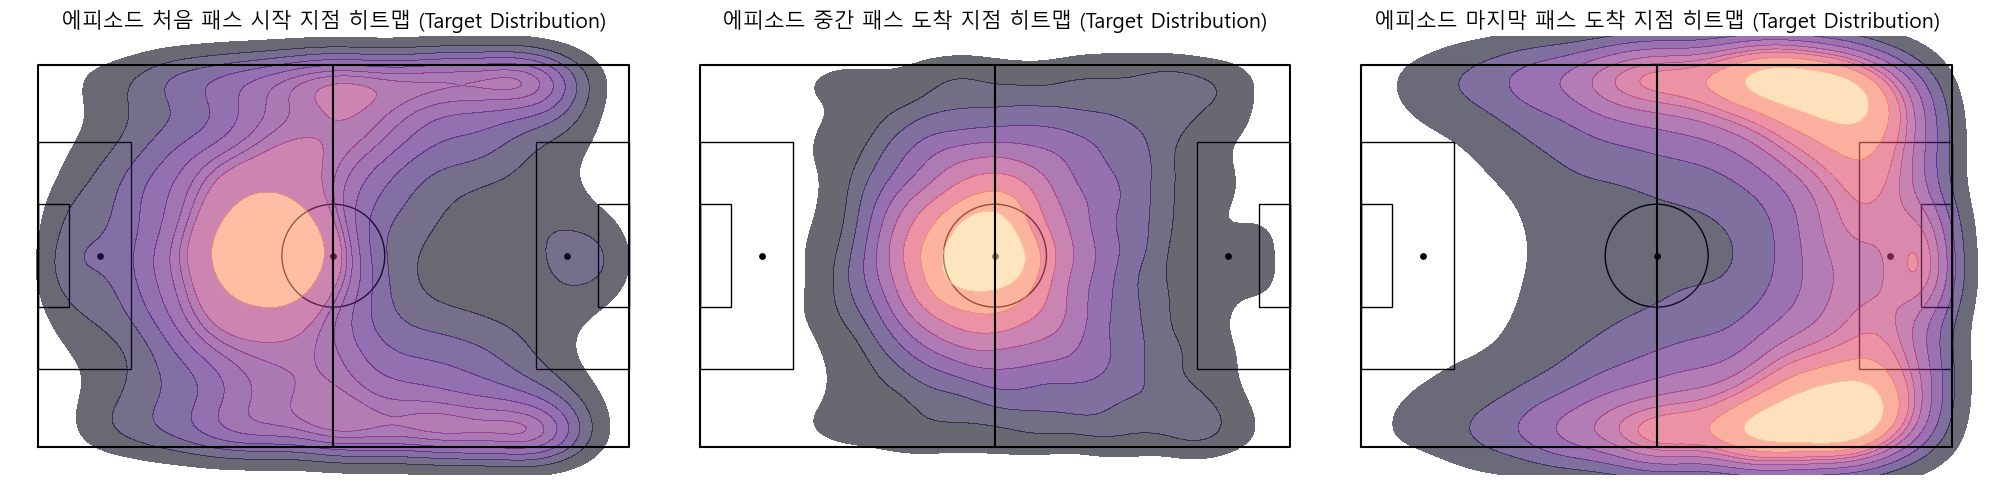

In [30]:
first_events = pass_df.groupby('game_episode').first()
last_events = pass_df.groupby('game_episode').last()

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
draw_pitch(axes[0])

# 2D 히트맵으로 표현 (kdeplot)
sns.kdeplot(
    x=first_events['end_x'], 
    y=first_events['end_y'], 
    fill=True, 
    cmap='magma', 
    alpha=0.6, 
    ax=axes[0],
    levels=10
)
axes[0].set_title('에피소드 처음 패스 시작 지점 히트맵 (Target Distribution)', fontsize=15)

median_events = pass_df.groupby('game_episode').median(numeric_only=True)
draw_pitch(axes[1])

# 2D 히트맵으로 표현 (kdeplot)
sns.kdeplot(
    x=median_events['end_x'], 
    y=median_events['end_y'], 
    fill=True, 
    cmap='magma', 
    alpha=0.6, 
    ax=axes[1],
    levels=10
)
axes[1].set_title('에피소드 중간 패스 도착 지점 히트맵 (Target Distribution)', fontsize=15)

draw_pitch(axes[2])

# 2D 히트맵으로 표현 (kdeplot)
sns.kdeplot(
    x=last_events['end_x'], 
    y=last_events['end_y'], 
    fill=True, 
    cmap='magma', 
    alpha=0.6, 
    ax=axes[2],
    levels=10
)
axes[2].set_title('에피소드 마지막 패스 도착 지점 히트맵 (Target Distribution)', fontsize=15)
plt.tight_layout()
plt.show()

- 왼쪽에서 오른쪽 방향으로 이동
- 공 위치기 왼쪽 가운데 오른쪽으로 이동하려는 경향 보임

## 3-6. 이벤트 타입별 이동거리 계산

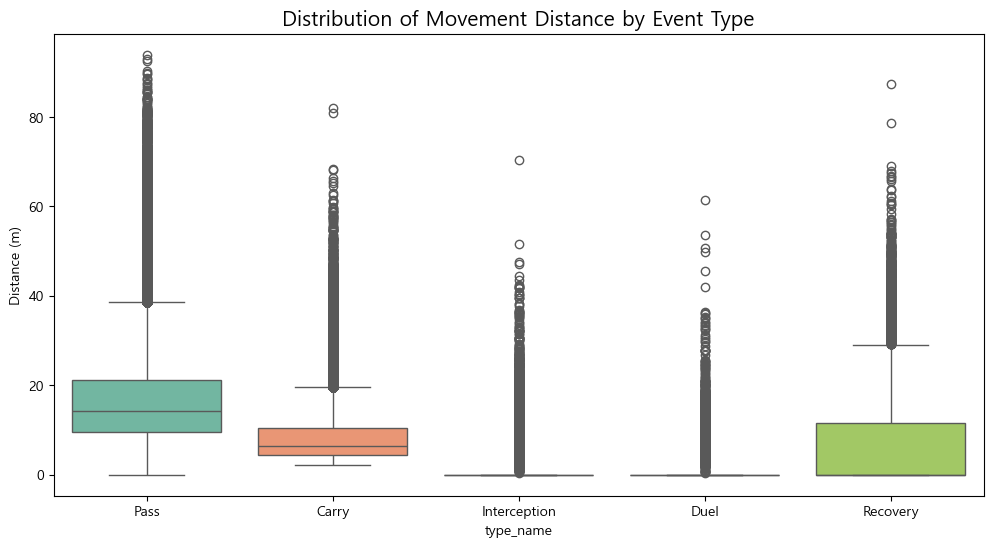

In [31]:
df_processed['distance']= np.sqrt((df_processed['end_x'] - df_processed['start_x'])**2 + (df_processed['end_y'] - df_processed['start_y'])**2)

# 주요 이벤트 거리 분포 확인
main_events_type = df_processed['type_name'].value_counts().head().index.tolist()
df_main_events = df_processed[df_processed['type_name'].isin(main_events_type)]

plt.figure(figsize=(12,6))
sns.boxplot(data=df_main_events, x='type_name', y='distance', palette='Set2')
plt.title('Distribution of Movement Distance by Event Type', fontsize=15)
plt.ylabel('Distance (m)')
plt.show()

In [32]:
df_processed.groupby('type_name')['distance'].mean()

type_name
Aerial Clearance     0.000000
Block                0.000000
Carry                8.514605
Catch                0.042699
Clearance           20.630743
Cross               24.324445
Deflection           0.000000
Duel                 1.228732
Error                0.000000
Foul                 0.000000
Goal Kick           34.782689
Handball_Foul        0.000000
Hit                  0.000000
Interception         1.983329
Intervention         0.000000
Parry                0.000000
Pass                16.841951
Pass_Corner         27.104798
Pass_Freekick       23.273916
Penalty Kick        11.221406
Recovery             6.774376
Shot                10.575371
Shot_Freekick       20.282152
Tackle               0.473103
Take-On              0.000000
Throw-In            14.340580
Name: distance, dtype: float64

- 패스에선 아웃라이어는 롱패스에 해당 하는 것으로 보임

In [33]:
df_processed.columns

Index(['game_id', 'period_id', 'episode_id', 'time_seconds', 'team_id',
       'player_id', 'action_id', 'type_name', 'result_name', 'start_x',
       'start_y', 'end_x', 'end_y', 'is_home', 'game_episode', 'game_date',
       'month', 'is_time_outlier', 'distance'],
      dtype='object')

## 시간별 패스 이동 거리

In [51]:
df_pre

,game_id,period_id,episode_id,time_seconds,team_id,player_id,action_id,result_name,start_x,start_y,end_x,end_y,is_home,game_episode,month,is_time_outlier,distance,start_x_n,start_y_n,end_x_n,end_y_n,angle_rad,angle_deg,angle_norm,time_delta_log,time_cat,velocity,velocity_norm,x_zone,y_zone,zone_id,distance_bin,distance_bin_norm,prev_angle_deg,relative_angle_norm,prev_1_end_x_n,prev_1_end_y_n,prev_1_dist,prev_1_result,is_overtime,player_hist_dist,team_hist_end_x,type_name_reduced_Block,type_name_reduced_Carry,type_name_reduced_Clearance,type_name_reduced_Duel,type_name_reduced_Interception,type_name_reduced_Intervention,type_name_reduced_Other,type_name_reduced_Pass,type_name_reduced_Recovery,type_name_reduced_Tackle,type_name_reduced_Throw-In,season_group_Autumn,season_group_Spring,season_group_Summer
0,126283,1,1,0.667,2354,344559,0,Successful,52.418205,33.485444,31.322445,38.274752,1,126283_1,3,0,21.632581,0.499221,0.492433,0.298309,0.562864,2.918350,167.209120,0.964470,0.000000,0,0.000000,0.000000,1,1,4,2,0.666667,0.000000,0.964470,0.000000,0.000000,0.000000,Unknown,0,0.000000,0.000000,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,126283,1,1,3.667,2354,250036,2,Successful,32.013240,38.100808,37.371285,30.632980,1,126283_1,3,0,9.191143,0.304888,0.560306,0.355917,0.450485,-0.948432,-54.341176,0.349052,1.386294,0,3.063714,0.180218,0,1,1,1,0.333333,167.209120,0.884583,0.298309,0.562864,21.632581,Successful,0,0.000000,31.322445,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,126283,1,1,4.968,2354,500145,4,Completed,37.371285,30.632980,38.391570,24.613144,1,126283_1,3,0,6.105686,0.355917,0.450485,0.365634,0.361958,-1.402905,-80.380514,0.276721,0.833344,0,4.693072,0.276063,1,1,4,1,0.333333,-54.341176,0.427669,0.355917,0.450485,9.191143,Successful,0,0.000000,34.346865,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,126283,1,1,8.200,2354,500145,5,Successful,38.391570,24.613144,34.573350,5.545468,1,126283_1,3,0,19.446210,0.365634,0.361958,0.329270,0.081551,-1.768428,-101.323468,0.218546,1.442675,1,6.016773,0.353928,1,1,4,2,0.666667,-80.380514,0.441825,0.365634,0.361958,6.105686,Completed,0,6.105686,35.695100,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,126283,1,1,11.633,2354,142106,7,Successful,34.578705,6.058256,21.274470,18.437112,1,126283_1,3,0,18.172472,0.329321,0.089092,0.202614,0.271134,2.392210,137.063513,0.880732,1.489077,1,5.293467,0.311380,0,0,0,2,0.666667,-101.323468,0.162186,0.329270,0.081551,19.446210,Successful,0,0.000000,35.414662,0,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356716,126480,2,85,2887.667,4220,143588,2905,Successful,37.357110,20.782296,62.394465,4.904160,0,126480_85,10,0,29.647670,0.355782,0.305622,0.594233,0.072120,-0.565172,-32.381965,0.410050,0.000000,0,0.000000,0.000000,1,0,3,2,0.666667,-32.381965,0.500000,0.594233,0.072120,29.647670,Completed,0,13.877244,52.217073,0,0,0,0,0,0,0,1,0,0,0,1,0,0
356717,126480,2,85,2889.934,4220,500530,2907,Completed,62.394465,4.904160,76.747020,17.890664,0,126480_85,10,0,19.355752,0.594233,0.072120,0.730924,0.263098,0.735473,42.139480,0.617054,1.183872,0,8.538047,0.502238,1,0,3,2,0.666667,-32.381965,0.707004,0.594233,0.072120,29.647670,Successful,0,9.965361,52.217411,0,1,0,0,0,0,0,0,0,0,0,1,0,0
356718,126480,2,85,2896.200,4220,500530,2908,Successful,76.747020,17.890664,86.547720,25.628656,0,126480_85,10,0,12.487203,0.730924,0.263098,0.824264,0.376892,0.668327,38.292314,0.606368,1.983206,1,1.992851,0.117227,2,0,6,1,0.333333,42.139480,0.489313,0.730924,0.263098,19.355752,Completed,0,9.974364,52.218225,0,0,0,0,0,0,0,1,0,0,0,1,0,0
356719,126480,2,87,3017.600,4639,250896,2913,Successful,5.342620,24.988164,63.547890,1.930724,1,126480_87,10,0,62.605902,0.050882,0.367473,0.605218,0.028393,-0.377174,-21.610503,0.439971,0.000000,0,0.000000,0.000000,0,1,1,3,1.000000,0.000000,0.439971,0.000000,0.000000,0.000000,Unknown,0,20.287697,49.592793,

         sec_bin       mean   count
0     [0.0, 1.0)  11.114797  101684
1     [1.0, 2.0)  11.319481  126616
2     [2.0, 3.0)  13.922259   70412
3     [3.0, 4.0)  15.070304   31230
4     [4.0, 5.0)  15.765312   12881
5     [5.0, 6.0)  16.350359    6155
6     [6.0, 7.0)  16.828083    3019
7     [7.0, 8.0)  18.561315    1636
8     [8.0, 9.0)  19.352922     894
9    [9.0, 10.0)  21.199377     490
10  [10.0, 11.0)  26.159295     322
11  [11.0, 12.0)  29.797150     241
12  [12.0, 13.0)  30.529157     193
13  [13.0, 14.0)  31.152352     143
14  [14.0, 15.0)  35.264548     109
15  [15.0, 16.0)  38.059040      70
16  [16.0, 17.0)  39.944476      39
17  [17.0, 18.0)  42.196520      48
18  [18.0, 19.0)  38.296384      32
19  [19.0, 20.0)  39.508677      18


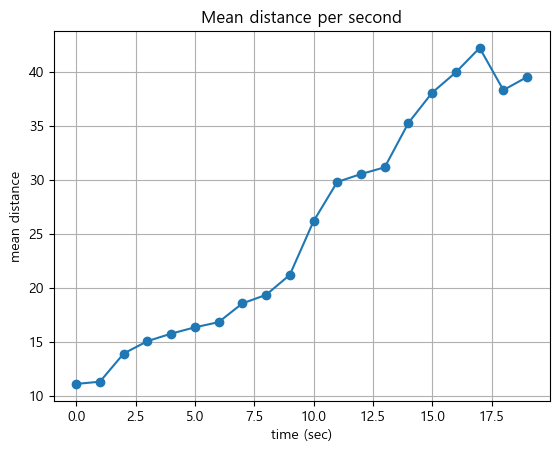

In [54]:
bins = np.arange(0, df_pre["time_delta"].max() + 1, 1)

df_pre["sec_bin"] = pd.cut(df_pre["time_delta"], bins=bins, right=False)

mean_per_sec = (
    df_pre.groupby("sec_bin")["distance"].agg(['mean', 'count']).reset_index()
)

print(mean_per_sec.head(20))

mean_per_sec["sec"] = mean_per_sec["sec_bin"].apply(lambda x: x.left)

plt.plot(mean_per_sec["sec"].head(20), mean_per_sec["mean"].head(20), marker="o")
plt.xlabel("time (sec)")
plt.ylabel("mean distance")
plt.title("Mean distance per second")
plt.grid(True)
plt.show()

## 3-7 이벤트별 경과 시간

In [35]:
# Pass 액션만 필터링
df_pass = df_processed[df_processed['type_name'].str.contains('Pass', na=False)].copy()

# gameepisode별로 그룹화하여 시간 차이 계산
df_pass = df_pass.sort_values(['game_id', 'period_id', 'episode_id', 'time_seconds'])
df_pass['time_delta'] = df_pass.groupby(['game_id', 'episode_id'])['time_seconds'].diff()

# 평균 시간 계산
avg_time_between_passes = df_pass['time_delta'].mean()
median_time_between_passes = df_pass['time_delta'].median()

print(f"패스 간 평균 시간: {avg_time_between_passes:.2f}초")
print(f"패스 간 중앙값 시간: {median_time_between_passes:.2f}초")

# 추가 통계
print("\n패스 간 시간 통계:")
print(df_pass['time_delta'].describe())

# 백분위수
percentiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
print("\n백분위수별 패스 간 시간:")
for p in percentiles:
    val = df_pass['time_delta'].quantile(p)
    print(f"{p*100:5.1f}%: {val:6.2f}초")


패스 간 평균 시간: 3.80초
패스 간 중앙값 시간: 2.97초

패스 간 시간 통계:
count    168108.000000
mean          3.795377
std           4.815610
min           0.000000
25%           1.991000
50%           2.967000
75%           4.533000
max         655.822000
Name: time_delta, dtype: float64

백분위수별 패스 간 시간:
 25.0%:   1.99초
 50.0%:   2.97초
 75.0%:   4.53초
 90.0%:   6.73초
 95.0%:   8.57초
 99.0%:  14.60초


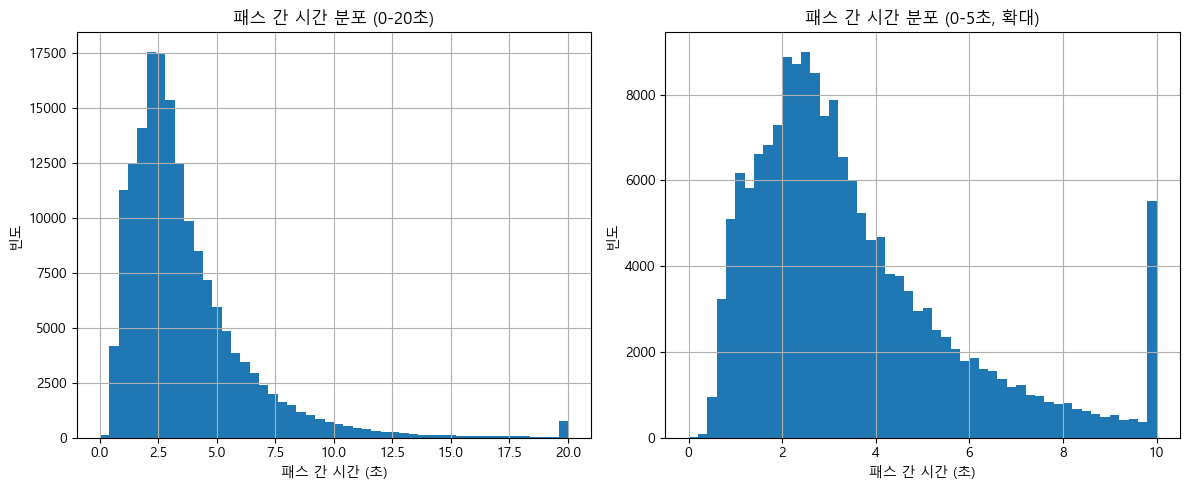

In [36]:
# 히스토그램
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df_pass['time_delta'].dropna().clip(0, 20).hist(bins=50)
plt.xlabel('패스 간 시간 (초)')
plt.ylabel('빈도')
plt.title('패스 간 시간 분포 (0-20초)')

plt.subplot(1, 2, 2)
df_pass['time_delta'].dropna().clip(0, 10).hist(bins=50)
plt.xlabel('패스 간 시간 (초)')
plt.ylabel('빈도')
plt.title('패스 간 시간 분포 (0-5초, 확대)')

plt.tight_layout()
plt.show()

- 숏패스가 주로 보이는 경향

### 3-.. 상관분석


>>> 5. Correlation Analysis (Numeric Features)


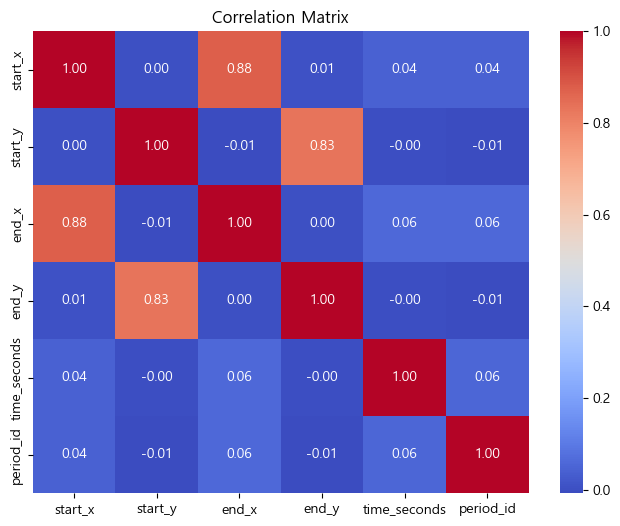

In [37]:
print("\n>>> 5. Correlation Analysis (Numeric Features)")
# 좌표와 시간 간의 상관관계
corr_cols = ['start_x', 'start_y', 'end_x', 'end_y', 'time_seconds', 'period_id']
corr = df_processed[corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

- start -> end (x,y) 좌표만 강한 상관관계를 보임